In [1]:
import numpy as np
import os
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import patches

import scipy.io.wavfile as wav
import datetime as dt
from pathlib import Path

from torch import multiprocessing
from tqdm import tqdm

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [3]:
from src.cfg import get_config
from src.pipeline import pipeline

In [237]:
def plt_msds(filename, audio, fs, reftimes, times, p_on=1):
    ## Make sure given times are within audio file
    #  If times extend beyond file, reduce times to file boundaries
    times[times < 0] = 0
    times[times > len(audio)/fs] = int(len(audio)/fs)
    audio = audio[times[0]*fs:times[1]*fs]

    ## Strip the datetime for year, month, date, and hour from filename
    file_dt = dt.datetime.strptime(filename[:15], '%Y%m%d_%H%M%S')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    time_labels = np.array([dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour, 
                                        minute=file_dt.minute + int(sec/60), second=int(sec%60), 
                                        microsecond=np.round(1e6*(sec%60-int(sec%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                        for sec in sec_labels])

    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params(filename, reftimes+times)

    ## Create figure
    plt.figure(figsize=(12, 9))

    ## Plotting Audio Signal
    plt.subplot(311)
    plt.title(f"{100*p_on}% Duty Cycle")
    plt.plot(audio)
    plt.ylabel("Amplitude (kU)")
    plt.xlim((0, s_ticks[-1]*fs))
    plt.xticks(ticks=x_ticks, labels=time_labels)
    amp_ticks = plt.yticks()[0]
    amp_ticks = np.insert(amp_ticks, 0, -1*amp_ticks[-1])
    plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
    plt.ylim((amp_ticks[0], amp_ticks[-1]))
    plt.grid(which="both")

    ## Plotting Spectrogram of Audio Signal
    plt.subplot(312)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

    ## Plotting Spectrogram with MSDS outputs overlayed
    plt.subplot(313)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.xlabel("Time (HH:MM:SS)")
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
    ax = plt.gca()
    for i in range(len(xs_inds)):
        rect = Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=1, edgecolor='y', facecolor='none')
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio) and audio[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

def get_msds_params(filename:str, times):
    csv_file = f'../output_dir/BatDetectorMSDS-{filename}.csv'
    df = pd.read_csv(csv_file)
    s_times = df['start_time']
    e_times = df['end_time']
    s_freqs = df['low_freq']
    e_freqs = df['high_freq']
    det_labels = df['event'].values
    xs_inds = s_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xe_inds = e_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xs_freqs = s_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    xe_freqs = e_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    x_durations = xe_inds - xs_inds
    x_bandwidths = xe_freqs - xs_freqs

    return xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels

# def plt_msds_fromdf(filename, df, audio_sec, fs, offset, reftimes, times, p_on):
#     ## Strip the datetime for year, month, date, and hour from filename
#     file_dt = dt.datetime.strptime(f'{filename[:11]}{int(offset/60)}{int(offset%60)}', '%Y%m%d_%H%M%S')

#     ## Only find numPoints amount of labels from all available seconds
#     numPoints = 11
#     seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
#     idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
#     sec_labels = reftimes[0] + seconds[idx]

#     ## Calculate Time Labels for X-Axis using Datetime objects as Strings
#     time_labels = np.array([dt.datetime(year=file_dt.year, month=file_dt.month, 
#                                         day=file_dt.day, hour=file_dt.hour, 
#                                         minute=file_dt.minute + int((file_dt.second + sec)/60), second=int((file_dt.second + sec)%60), 
#                                         microsecond=np.round(1e6*((file_dt.second + sec)%60-int((file_dt.second + sec)%60))).astype('int32')).strftime('%T.%f')[:-4] 
#                                         for sec in sec_labels])

#     ## Find x-axis tick locations from all available seconds and convert to samples
#     s_ticks = seconds[idx]-times[0]
#     x_ticks = s_ticks*fs
#     s_ticks

#     ## Calculate detection parameters from msds output to use for drawing rectangles
#     xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params_from_df(df, reftimes[0]+times)

#     ## Create figure
#     plt.figure(figsize=(12, 9))

#     ## Plotting Audio Signal
#     plt.subplot(311)
#     plt.title(f"{100*p_on}% Duty Cycle")
#     plt.plot(audio_sec)
#     plt.ylabel("Amplitude (kU)")
#     plt.xlim((0, s_ticks[-1]*fs))
#     plt.xticks(ticks=x_ticks, labels=time_labels)
#     amp_ticks = plt.yticks()[0]
#     amp_ticks = np.insert(amp_ticks, 0, -1*amp_ticks[-1])
#     plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
#     plt.ylim((amp_ticks[0], amp_ticks[-1]))
#     plt.grid(which="both")

#     ## Plotting Spectrogram of Audio Signal
#     plt.subplot(312)
#     plt.specgram(audio_sec, Fs=fs, cmap='ocean')
#     plt.ylabel("Frequency (kHz)")
#     plt.xticks(ticks=s_ticks, labels=time_labels)
#     plt.xlim((0, s_ticks[-1]))
#     ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
#     f_ticks = plt.yticks()[0]
#     f_ticks = f_ticks[f_ticks <= fs/2]
#     plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

#     ## Plotting Spectrogram with MSDS outputs overlayed
#     plt.subplot(313)
#     plt.specgram(audio_sec, Fs=fs, cmap='ocean')
#     plt.xlim((0, s_ticks[-1]))
#     plt.xlabel("Time (HH:MM:SS)")
#     plt.ylabel("Frequency (kHz)")
#     plt.xticks(ticks=s_ticks, labels=time_labels)
#     plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
#     ax = plt.gca()
#     for i in range(len(xs_inds)):
#         rect = Rectangle((xs_inds[i], xs_freqs[i]), 
#                         x_durations[i], x_bandwidths[i], 
#                         linewidth=1, edgecolor='y', facecolor='none')
#         if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio_sec) and audio_sec[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
#             ax.add_patch(rect)
#     plt.gcf().autofmt_xdate()

#     plt.tight_layout()
#     plt.show()

def plt_msds_fromdf(location, filename, df, audio_sec, fs, offset, reftimes, times, cycle_length, p_on, be_subplot=False, show_PST=False, show_legend=False, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB = -140, save=False):
    ## Strip the datetime for year, month, date, and hour from filename
    hour = int(filename[9:11])
    if (show_PST):
        if (hour > 7):
            hour = hour - 7
        else:
            hour = 24 + hour - 7
    zero_pad_hour = str(hour).zfill(1)
    file_dt = dt.datetime.strptime(f'{filename[:9]}{zero_pad_hour}{int(offset/60)%60}{int(offset%60)}', '%Y%m%d_%H%M%S')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    if times[1] < 400:
        if times[1] < 150:
            time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                                day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                                minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60), 
                                                microsecond=np.round(1e6*((file_dt.second + sec)%60-int((file_dt.second + sec)%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                                for sec in sec_labels]
        else:
            time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                            day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                            minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60)).strftime('%T')
                                            for sec in sec_labels]
    else:
        time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                            day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                            minute=(file_dt.minute + int((file_dt.second + sec)/60))%60).strftime('%T') 
                                            for sec in sec_labels]
    
    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params_from_df(df, reftimes[0]+times)
    vmin = 20*np.log10(np.max(audio_sec)) - rm_dB  # hide anything below -rm_dB dB

    ## Create figure
    legend_fontsize = 16
    ylabel_fontsize=20
    if (show_audio):
        if (times[1] < 1200):
            plt.figure(figsize=(18, 12))
            # Plotting Audio Signal
            plt.subplot(311)
        else:
            plt.figure(figsize=(8, 2.5))
            # Plotting Audio Signal
            plt.subplot(211)

        plt.title(f"")
        plt.plot(audio_sec)
        plt.xlim((0, s_ticks[-1]*fs))
        plt.xticks(ticks=x_ticks, labels=time_labels)
        amp_ticks = plt.yticks()[0]
        # plt.ylabel("Amplitude (V)", fontsize=20)
        if (np.max(amp_ticks) > 1000):
            plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
            plt.ylabel("Amplitude (kV)")

        plt.yticks(fontsize=20)
        plt.ylim((-0.5, 0.5))
        plt.grid(which="both")

        
        ## Plotting Spectrogram of Audio Signal
        if (times[1] < 1200):
            plt.subplot(312)
            plt.title(f"Spectrogram Representation showing Frequencies {0} to {fs//2000}kHz")
            plt.specgram(audio_sec, NFFT=812, Fs=fs, cmap=spec_cmap, vmin=vmin)
            plt.ylabel("Frequency (kHz)", fontsize=ylabel_fontsize)
            plt.xticks(ticks=s_ticks, labels=time_labels)
            plt.xlim((0, s_ticks[-1]))
            ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
            f_ticks = plt.yticks()[0]
            f_ticks = f_ticks[f_ticks <= fs/2]
            plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

            ## Plotting Spectrogram with MSDS outputs overlayed
            plt.subplot(313)
        else:
            if (show_spectrogram):
                plt.subplot(212)
        plt.title(f"")
    else:
        if (not(be_subplot)):
            plt.figure(figsize=(18, 4))
            plt.title(f"{file_dt.date()} in {location} | {cycle_length//60}-min, {100*p_on:.1f}% Duty Cycle")
    if (show_spectrogram):
        print("Plot spectrogram")
        plt.specgram(audio_sec, NFFT=812, Fs=fs, cmap=spec_cmap, vmin=vmin)
    plt.xlim((0, s_ticks[-1]))
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    if (show_PST):
        plt.xlabel("PST Time (HH:MM:SS)")
    else:
        plt.xlabel("UTC Time (HH:MM:SS)")
    # Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
    plt.ylim(0, 105000)
    ax = plt.gca()
    print(xs_inds)
    for i in range(len(xs_inds)):
        rect = patches.Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=3, edgecolor='yellow', facecolor='none', alpha=0.8)
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio_sec) and audio_sec[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
    if (show_spectrogram):
        on_color = "yellow"
        on_alpha = 0.2
    else:
        on_color = 'black'
        on_alpha = 1.0
    if (not(show_audio)):
        for tick in sec_labels:
            if (p_on < 1.0 and int(tick)%cycle_length == 0):
                rect = patches.Rectangle((int(tick)-reftimes[0], 0), width=int(p_on*cycle_length), height=96000, linewidth=1, edgecolor=on_color, facecolor=on_color, alpha=on_alpha)
                ax.add_patch(rect)
            if (p_on == 1.0 and tick%(reftimes[1] - reftimes[0]) == 0):
                rect = patches.Rectangle((int(tick)-reftimes[0], 0), width=int(audio_sec.shape[0] / fs), height=96000, linewidth=1, edgecolor=on_color, facecolor=on_color, alpha=on_alpha)
                ax.add_patch(rect)

        if (show_spectrogram):
            yellow_rect = patches.Patch(edgecolor=on_color, facecolor=on_color, label = "Detections")
            green_rect = patches.Patch(edgecolor='yellow', facecolor="green", alpha = 0.5, label="Simulated Recording Period")
            blue_rect = patches.Patch(edgecolor='k', facecolor="royalblue", alpha=0.8, label="Simulated Sleep Period")
            if (show_legend):
                if (p_on < 1.0):
                    if (sec_labels[0]==0):
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, loc=1)
                    else:
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, loc=2)
                else:
                    if (sec_labels[0]==0):
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, ncol=3, loc=1)
                    else:
                        plt.legend(handles=[green_rect, blue_rect, yellow_rect], fontsize=legend_fontsize, ncol=3, loc=2)
    else: 
        if (show_spectrogram):
            if (show_legend):
                yellow_rect = patches.Patch(edgecolor=on_color, facecolor=on_color, label = "Detections")
                if (sec_labels[0]==0):
                    plt.legend(handles=[yellow_rect], fontsize=legend_fontsize, loc=1)
                else:
                    plt.legend(handles=[yellow_rect], fontsize=legend_fontsize, loc=2)
    if (show_spectrogram):
        plt.gcf().autofmt_xdate()
    plt.tight_layout()
    if (save):
        directory = f'{Path.home()}/Documents/UBNA/Symposium/Figures/spectrograms/{dt.datetime.strftime(file_dt, "%Y%m%d")}'
        start_datetime = dt.datetime.strftime(dt.datetime.strptime(time_labels[0], "%H:%M:%S.%f"), "%H%M%S")
        end_datetime = dt.datetime.strftime(dt.datetime.strptime(time_labels[-1], "%H:%M:%S.%f"), "%H%M%S")
        if not os.path.isdir(directory):
            os.makedirs(directory)

        if (not(show_audio)):
            directory = f'{directory}/{int(cycle_length*p_on)//60}min_every_{cycle_length//60}min'
            if not os.path.isdir(directory):
                os.makedirs(directory)
            plt.savefig(
                f'{directory}/{location.split()[0]}{location.split()[1]}__{start_datetime}to{end_datetime}.png')
        else:
            directory = f'{directory}/examples'
            if not os.path.isdir(directory):
                os.makedirs(directory)
            plt.savefig(
                f'{directory}/{location.split()[0]}{location.split()[1]}__{start_datetime}to{end_datetime}.png')
    if (not(be_subplot)):
        plt.show()

def get_msds_params_from_df(dets:pd.DataFrame, times):
    df = dets
    s_times = df['start_time']
    e_times = df['end_time']
    s_freqs = df['low_freq']
    e_freqs = df['high_freq']
    det_labels = df['event'].values
    xs_inds = s_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xe_inds = e_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xs_freqs = s_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    xe_freqs = e_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    x_durations = xe_inds - xs_inds
    x_bandwidths = xe_freqs - xs_freqs

    return xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels

In [5]:
filepath = f"{Path.home()}/Downloads"
filename = "20210910_030000.WAV"

In [6]:
args = dict()
args["input_audio"] = f'{filepath}/{filename}'
args["output_directory"] = f'../output_dir/'
args["tmp_directory"] = f'../output/tmp'
args["csv"] = True
args["num_processes"] = 4

cfg = get_config()
cfg["should_csv"] = args["csv"]
cfg["output_dir"] = Path(args["output_directory"])
cfg["tmp_dir"] = Path(args["tmp_directory"])
cfg["audio_file"] = Path(f'{filepath}/{filename}')
cfg["num_processes"] = args["num_processes"]
cfg

{'time_expansion_factor': 1.0,
 'start_time': 0.0,
 'segment_duration': 30.0,
 'models': [<models.bat_call_detector.model_detector.BatCallDetector at 0x28f58d160>],
 'should_csv': True,
 'output_dir': PosixPath('../output_dir'),
 'tmp_dir': PosixPath('../output/tmp'),
 'audio_file': PosixPath('/Users/adityakrishna/Downloads/20210910_030000.WAV'),
 'num_processes': 4}

In [7]:
segmented_file_paths = pipeline.generate_segments(
        audio_file = cfg['audio_file'], 
        output_dir = cfg['tmp_dir'],
        start_time = cfg['start_time'],
        duration   = cfg['segment_duration'],
    )

audio_file_path = cfg['audio_file']
process_pool = multiprocessing.Pool(cfg['num_processes'])

l_for_mapping = [{
    'audio_seg': audio_seg, 
    'model': cfg['models'][0],
    'original_file_name': audio_file_path,
    } for audio_seg in segmented_file_paths]



In [8]:
l_for_mapping[48]

{'audio_seg': {'audio_file': '../output/tmp/20210910_030000__0.00_1440.00.wav',
  'offset': 1440.0},
 'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x28f58d160>,
 'original_file_name': PosixPath('/Users/adityakrishna/Downloads/20210910_030000.WAV')}

In [9]:
df = pd.DataFrame()
for i in range(40, 50):
    cur_seg = l_for_mapping[i]

    bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
    bd_preds = pipeline._correct_annotation_offsets(
            bd_annotations_df,
            cur_seg['original_file_name'],
            cur_seg['audio_seg']['offset']
        )

    fb_annotations_df = cur_seg['model']._run_feedbuzz(cur_seg['audio_seg']['audio_file'])
    fb_final_output = cur_seg['model']._buzzfeed_fp_removal(bd_annotations_df, fb_annotations_df)
    fb_preds = pipeline._correct_annotation_offsets(
            fb_final_output,
            cur_seg['original_file_name'],
            cur_seg['audio_seg']['offset']
        )
    
    df = pd.concat([df, fb_preds])

In [10]:
fb_preds_high_conf = df.loc[np.logical_and(df['detection_confidence'] < 0.324, df['detection_confidence'] >= 0.32)]
df

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,1245.314739,1245.603507,14512.23,47084.990,0.286955,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
0,1317.779277,1317.953562,19219.32,52865.600,0.269047,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
0,1322.239693,1322.384691,16007.88,49604.738,0.275856,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
1,1322.673459,1322.819277,16007.88,49604.738,0.276775,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
2,1323.305882,1323.451699,16007.88,49604.738,0.273695,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
...,...,...,...,...,...,...,...
1,1472.106061,1472.250138,18330.96,52959.200,0.283193,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
2,1472.626458,1472.763981,18330.96,52959.200,0.300665,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
3,1473.422720,1473.569254,18330.96,52959.200,0.284496,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...
4,1473.687219,1473.830579,16007.88,49604.738,0.277296,Feeding Buzz,/Users/adityakrishna/Downloads/20210910_030000...


In [11]:
## Make sure given times are within audio file
audio_file = sf.SoundFile(cfg["audio_file"])
fs = audio_file.samplerate
offset = 0
reftimes = [1405, 1410]
audio_file.seek(reftimes[0]*fs)
audio_sec = audio_file.read((reftimes[1] - reftimes[0])*fs)
times = np.array([0, reftimes[1] - reftimes[0]])
fbs = df.loc[df['high_freq'] < 47000]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


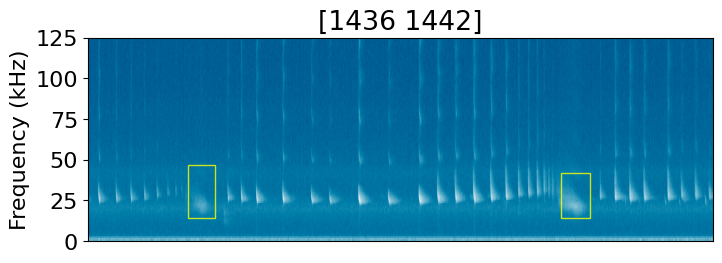

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


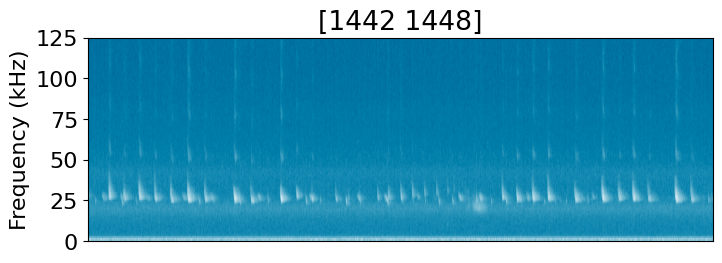

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


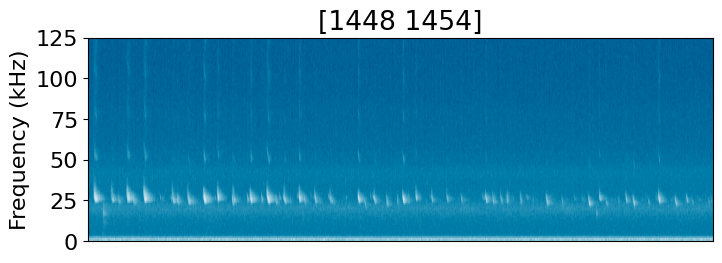

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


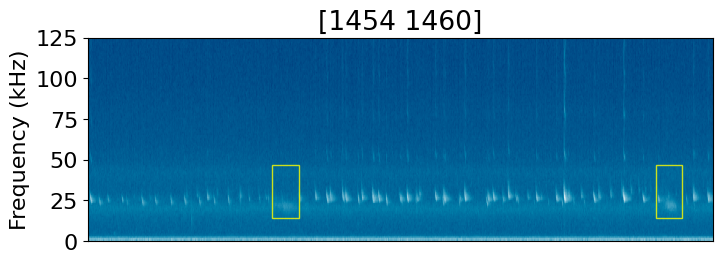

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


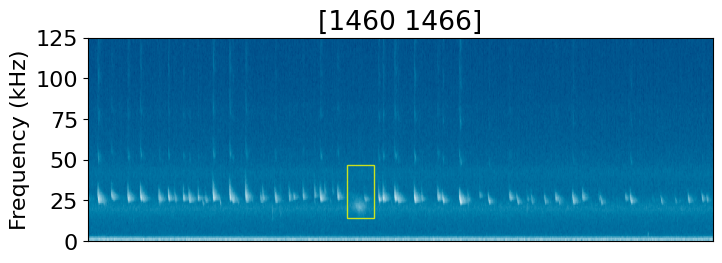

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


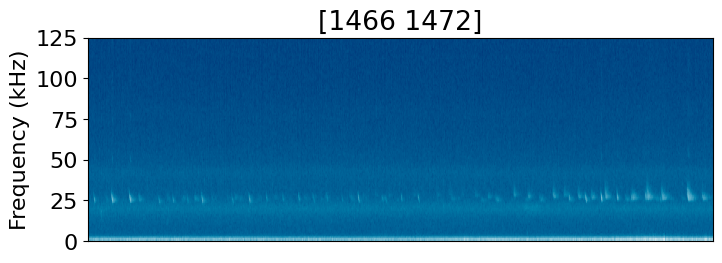

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


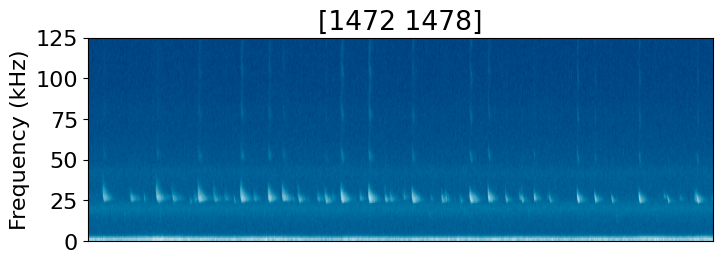

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


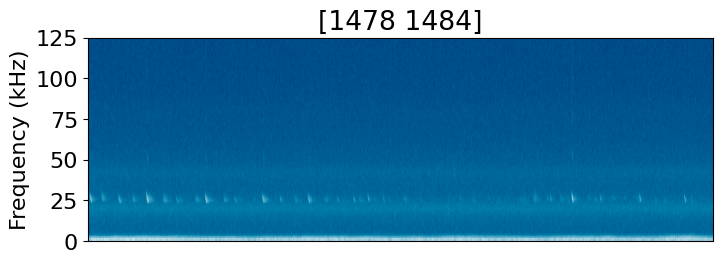

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


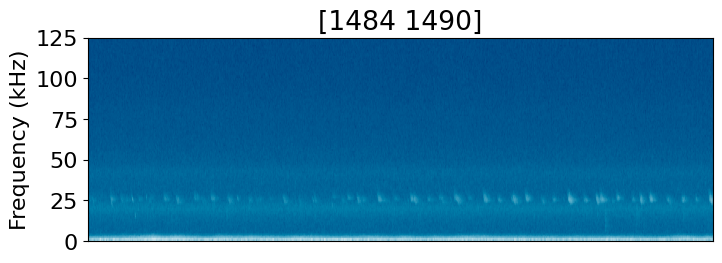

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


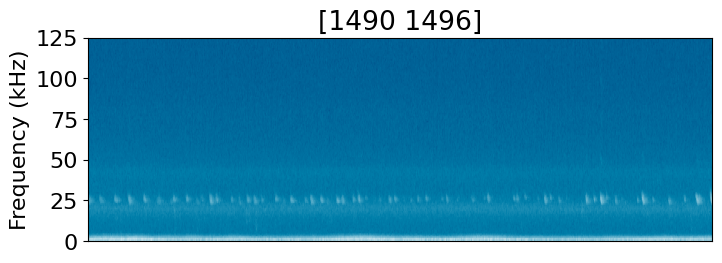

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


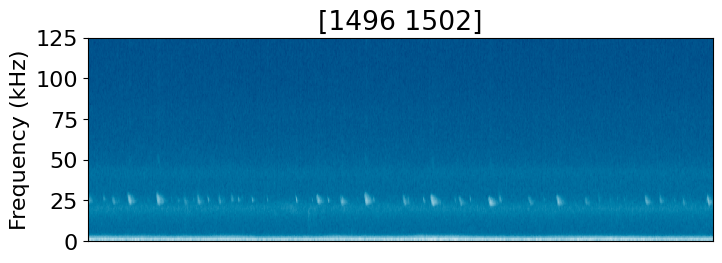

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


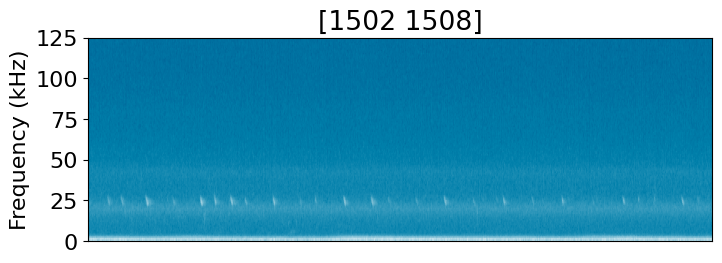

In [211]:
# for adjust in range(0, 70, 6):

#     audio_file = sf.SoundFile(cfg["audio_file"])
#     fs = audio_file.samplerate
#     offset = 0
#     reftimes = np.array([1436, 1442]) + adjust
#     # print(reftimes)
#     audio_file.seek(reftimes[0]*fs)
#     audio_sec = audio_file.read((reftimes[1] - reftimes[0])*fs)
#     times = np.array([0, reftimes[1] - reftimes[0]])

#     plt.figure(figsize=(8, 4))
#     plt.rcParams.update({'font.size': 16})
#     plt.title(f'{reftimes}')

#     plt_msds_fromdf("", filename, fbs, audio_sec, fs, offset, reftimes, times, 1800, 0.0, be_subplot=True, show_PST=True, show_legend=True, show_audio=False, show_spectrogram=True, save=False)

#     plt.legend().remove()
#     plt.xticks([], [])
#     plt.xlabel('')
#     plt.ylabel('Frequency (kHz)', fontsize=16)
#     plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


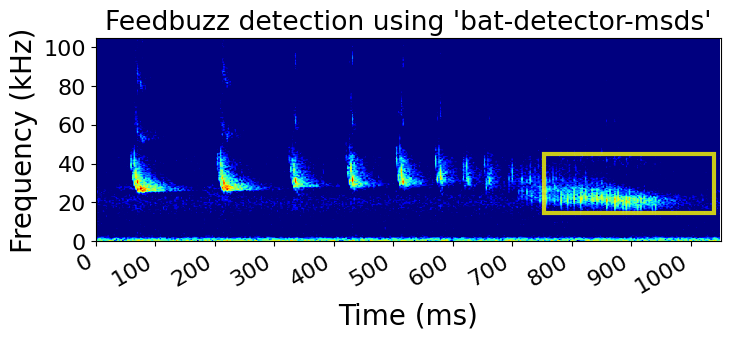

In [238]:
# for adjust in range(0, 300, 5):

audio_file = sf.SoundFile(cfg["audio_file"])
fs = audio_file.samplerate
offset = 0
reftimes = np.array([1439.8, 1440.85])
times = np.array([0, reftimes[1] - reftimes[0]])
step_size = 100
# print(reftimes)
audio_file.seek(int(reftimes[0]*fs))
audio_sec = audio_file.read(int((reftimes[1] - reftimes[0])*fs))

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 16})
plt.title(f'Feedbuzz detection using \'bat-detector-msds\'')

plt_msds_fromdf("", filename, fbs, audio_sec, fs, offset, reftimes, times, 1800, 0.0, be_subplot=True, show_PST=True, show_legend=True, show_audio=False, show_spectrogram=True, spec_cmap='jet', rm_dB = 90, save=False)

plt.legend().remove()
plt.xticks(np.linspace(0, times[1]-0.05, len(np.arange(0, 1000*times[1], step_size))), np.arange(0, 1000*times[1], step_size).astype('int'))
plt.yticks(np.linspace(0, 100000, 6), np.linspace(0, 100, 6).astype('int'))
plt.ylabel("Frequency (kHz)", fontsize=20)
plt.xlabel(f'Time (ms)', fontsize=20)
plt.show()

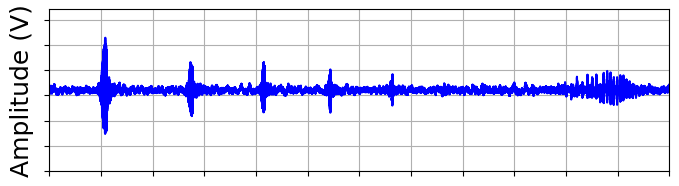

In [222]:

plt.rcParams.update({'font.size': 20})

## Strip the datetime for year, month, date, and hour from filename
hour = int(filename[9:11])
if (hour > 7):
    hour = hour - 7
else:
    hour = 24 + hour - 7
zero_pad_hour = str(hour).zfill(1)
file_dt = dt.datetime.strptime(f'{filename[:9]}{zero_pad_hour}{int(offset/60)%60}{int(offset%60)}', '%Y%m%d_%H%M%S')

## Only find numPoints amount of labels from all available seconds
numPoints = 11
seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
sec_labels = reftimes[0] + seconds[idx]

## Calculate Time Labels for X-Axis using Datetime objects as Strings
if times[1] < 400:
    if times[1] < 150:
        time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                            day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                            minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60), 
                                            microsecond=np.round(1e6*((file_dt.second + sec)%60-int((file_dt.second + sec)%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                            for sec in sec_labels]
    else:
        time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                        minute=(file_dt.minute + int((file_dt.second + sec)/60))%60, second=int((file_dt.second + sec)%60)).strftime('%T')
                                        for sec in sec_labels]
else:
    time_labels = [dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour + int((file_dt.minute + (sec/60))/60), 
                                        minute=(file_dt.minute + int((file_dt.second + sec)/60))%60).strftime('%T') 
                                        for sec in sec_labels]

## Find x-axis tick locations from all available seconds and convert to samples
s_ticks = seconds[idx]-times[0]
x_ticks = s_ticks*fs

## Calculate detection parameters from msds output to use for drawing rectangles
xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params_from_df(df, reftimes[0]+times)
vmin = 20*np.log10(np.max(audio_sec)) - 90  # hide anything below -rm_dB dB

## Create figure
legend_fontsize = 16
ylabel_fontsize=20
plt.figure(figsize=(8, 2.1))

plt.title(f"")
plt.plot(audio_sec, color='b')
plt.xticks(np.linspace(0, fs*times[1]-0.05, len(np.arange(0, 1000*times[1], step_size))), '')
plt.xlabel(f'', fontsize=20)
plt.xlim(0, 1.2*fs)
amp_ticks = plt.yticks()[0]
plt.ylabel("Amplitude (V)", fontsize=18)

plt.yticks(np.arange(-0.8, 0.81, 0.25), '')
plt.ylim((-0.8, 0.8))
plt.grid(which="both")